In [27]:
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.animation as anim
from numba import njit

In [6]:
mat = np.load(r"..\matrices\isolated-materials\float32\Transition1.npy")
img = mat[:,:,312]

(1085, 1085, 489)


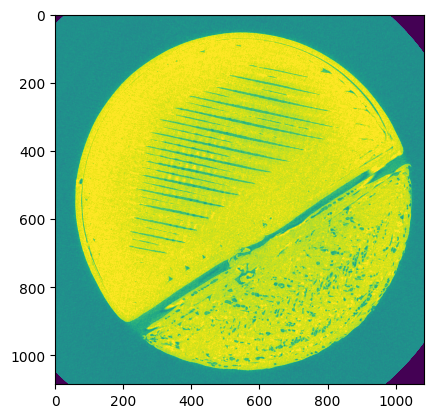

In [40]:
print(mat.shape)
plt.imshow(img, vmin=8000, vmax=12000)
plt.show()


Needs to accept seed locations of arbitrary amounts, keep track of which voxels are marked/unmarked, etc


In [22]:
# Testing 2D case
seeds = {(0,1084,1,0),
         (200,100,2,0),
         (100,1000,2,0),
         (1000,950,2,0),
         (1000,100,2,0),
         (0,0,1,0),
         (1084,0,1,0),
         (1084,1084,1,0),
         (882,806,3,0),
         (250,200,4,0),
         (353,899,4,0)}


bounds = [[0, 9500],
         [10020-393, 10020+393],
         [11627-431, 11627+431],
         [11902-445, 11902+445],
         [12329-567, 12329+567]
         ]
active = seeds
marked = np.zeros(img.shape, dtype=np.uint8)

# x, y, and m for material
for x,y,m,t in seeds:
    marked[x,y] = m

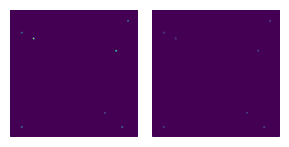

In [8]:
active_view = np.zeros(img.shape, np.bool_)
for x,y,m,t in active:
    active_view[x,y] = 1

fig, axs = plt.subplots(1,2)
fig.set_size_inches(4.5,2.25,forward=True)
im0 = axs[0].imshow(marked, animated=True)
im1 = axs[1].imshow(active_view, animated=True)
axs[0].axis(False)
axs[1].axis(False)

def update(pp):
    for _ in range(5):
        watershed_iterate()

    active_view = np.zeros(img.shape, np.bool_)
    for x,y,m,t in active:
        active_view[x,y] = 1
        
    im0.set_array(marked)
    im1.set_array(active_view)
    return im0,im1

anim_fig = anim.FuncAnimation(fig, update, frames=200, interval = 16.6667, blit=True)
plt.axis(False)
plt.tight_layout()
plt.show()

anim_fig.save("watershed1.gif")


In [30]:
def watershed_iterate():
    for x,y,m,t in active.copy():
        if t>4:
            active.remove((x,y,m,t))
            continue
        
        x_coords = np.array([x-1,x+1,x,x], dtype=np.int32)
        y_coords = np.array([y,y,y-1,y+1], dtype=np.int32)

        vs = np.zeros(4, dtype=np.uint8)

        current = img[x,y]
        lower = bounds[m-1][0]
        upper = bounds[m-1][1]

        if x==0:
            vs[0] = 255
        if x==img.shape[0]-1:
            vs[1] = 255
        if y==0:
            vs[2] = 255
        if y==img.shape[1]-1:
            vs[3] = 255

        for n in range(4):
            if vs[n] != 255:
                vs[n] = marked[x_coords[n], y_coords[n]]

        minVal = 1e12
        index = 255
        for n in range(4):
            if vs[n] == 0:
                next = img[x_coords[n], y_coords[n]]
                val = np.abs(current-next) if lower<=next<=upper else minVal+1000
                if val < minVal:
                    minVal = val
                    index = n

        if index == 255:
            active.remove((x,y,m,t))
            continue
        else:
            marked[x_coords[index], y_coords[index]] = m
            active.add((x_coords[index], y_coords[index], m, 0))

        for n in range(4):
            if vs[n] != 255:
                vs[n] = marked[x_coords[n], y_coords[n]]

        if np.min(vs) > 0:
            active.remove((x,y,m,t))
        else:
            active.remove((x,y,m,t))
            active.add((x,y,m,t+1))
    

In [34]:
for _ in range(512):
    watershed_iterate()

In [35]:
active_view = np.zeros(img.shape, np.bool_)
for x,y,m,t in active:
    active_view[x,y] = 1

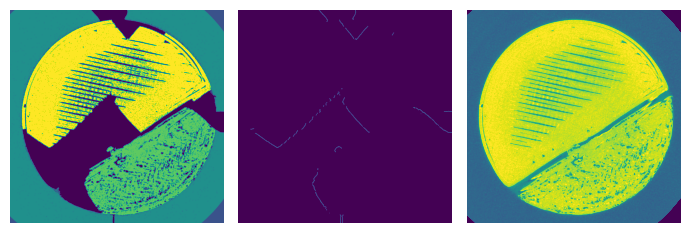

In [36]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(7,3)
axs[0].imshow(marked)
axs[1].imshow(active_view)
axs[2].imshow(img, vmin=9000, vmax=12000)
axs[0].axis(False)
axs[1].axis(False)
axs[2].axis(False)
fig.tight_layout()
plt.show()